In [1]:
from pathlib import Path

project_dir = Path('.').absolute().parent
project_dir

PosixPath('/home/daniel/Documents/github/mcx-lab/rl-baselines3-zoo')

In [2]:
import gym
import utils.import_envs

env = gym.make('A1GymEnv-v0', gait_name='trot')
env.observation_space.shape
print(env.all_sensors())
foot_names = env.robot.GetFootNames()
print(foot_names)

pybullet build time: Jan 19 2022 23:07:37


Init CPG gait=trot, duty_factor=0.71740707260901, period=0.5744965218643158
argv[0]=
[<blind_walking.envs.sensors.robot_sensors.BaseVelocitySensor object at 0x7f349828c190>, <blind_walking.envs.sensors.robot_sensors.IMUSensor object at 0x7f349828c100>, <blind_walking.envs.sensors.robot_sensors.MotorAngleSensor object at 0x7f349828c1c0>, <blind_walking.envs.sensors.robot_sensors.MotorVelocitySensor object at 0x7f3380a6ac40>, <blind_walking.envs.sensors.environment_sensors.LastActionSensor object at 0x7f3380a6abe0>, <blind_walking.envs.sensors.environment_sensors.ForwardTargetPositionSensor object at 0x7f3380a771f0>, <blind_walking.envs.sensors.cpg_sensors.ReferenceGaitSensor object at 0x7f3380a772e0>]
['FR_toe_fixed', 'FL_toe_fixed', 'RR_toe_fixed', 'RL_toe_fixed']


/home/daniel/anaconda3/envs/rl-baselines-zoo-cu113/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


# Inspect logged inputs / outputs

Logs generated with `scripts/enjoy_with_logging.py`

In [3]:
import numpy as np
import pickle 

def load_robot_states(stats_dir):
    motor_position = np.load(stats_dir / 'motor_position.npy')
    print(motor_position.shape)
    motor_velocity = np.load(stats_dir / 'motor_velocity.npy')
    feet_air_time = np.load(stats_dir / 'feet_air_time.npy')
    print(feet_air_time.shape)
    nn_observations = np.load(stats_dir / 'nn_observations.npy')
    print(nn_observations.shape)
    nn_actions = np.load(stats_dir / 'nn_actions.npy')
    print(nn_actions.shape)
    time = np.load(stats_dir / 'time.npy')
    
    return time, motor_position, motor_velocity, feet_air_time, nn_observations, nn_actions

def load_normalizer(model_dir):
    with open(model_dir / 'A1GymEnv-v0' / 'vecnormalize.pkl', 'rb') as file:
        normalizer = pickle.load(file)
    return normalizer

(1000, 12)
(1000, 4)


(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
[46.00000174 45.9999989  45.9999988  46.00000029]
[46.00000174 45.9999989  45.9999988  46.00000029]
[47.00000178 45.9999989  45.9999988  47.0000003 ]
[47.00000178 46.99999887 46.99999877 47.0000003 ]


[48.00000182 47.99999885 47.99999874 48.0000003 ]
[49.00000186 48.99999882 48.99999872 49.00000031]
[54.00000205 53.9999987  53.99999859 54.00000034]


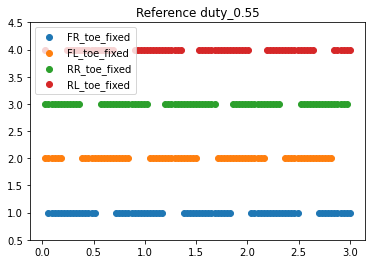

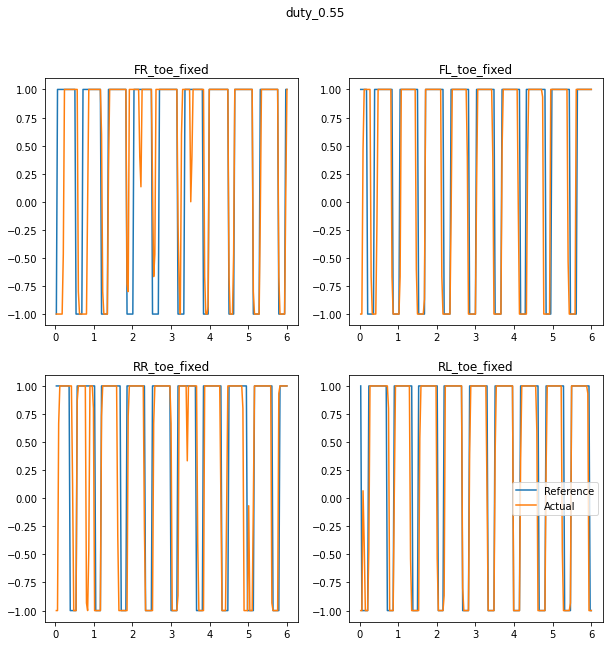

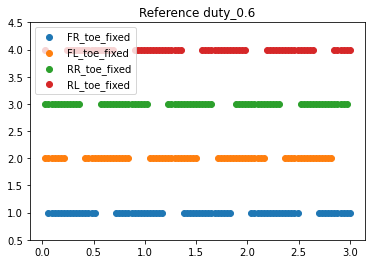

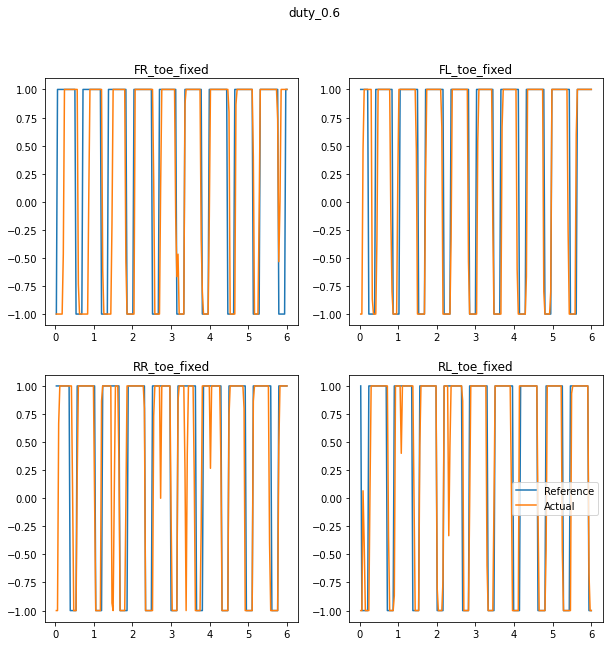

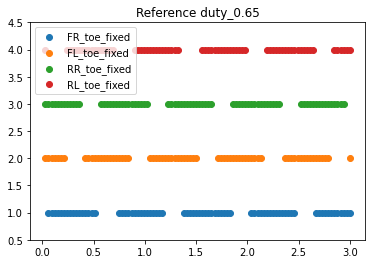

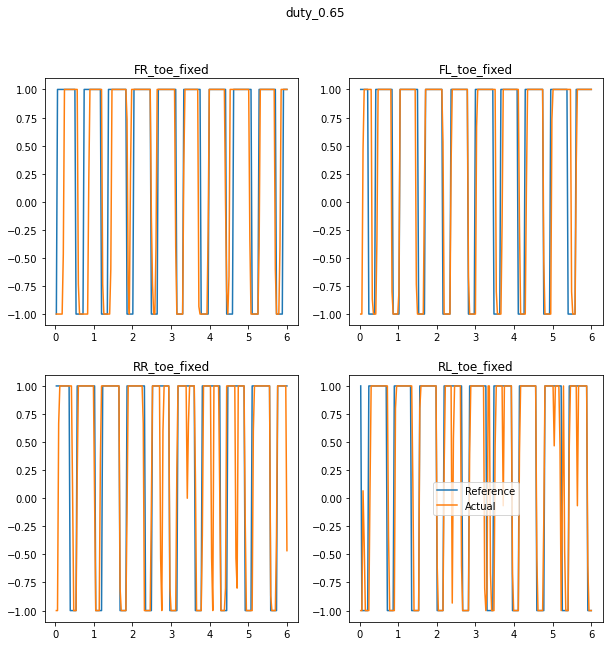

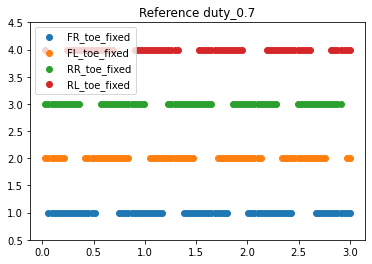

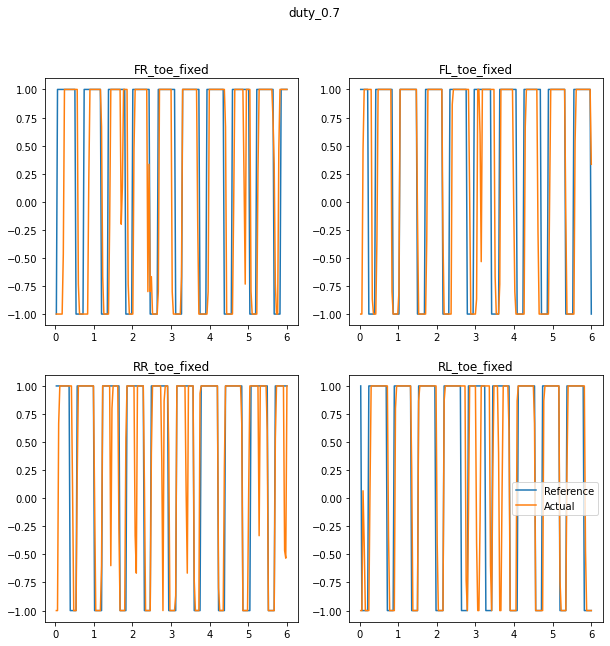

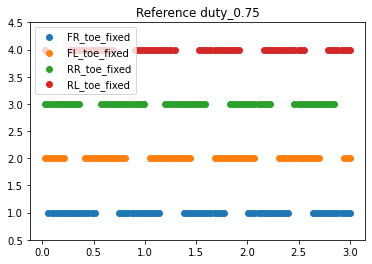

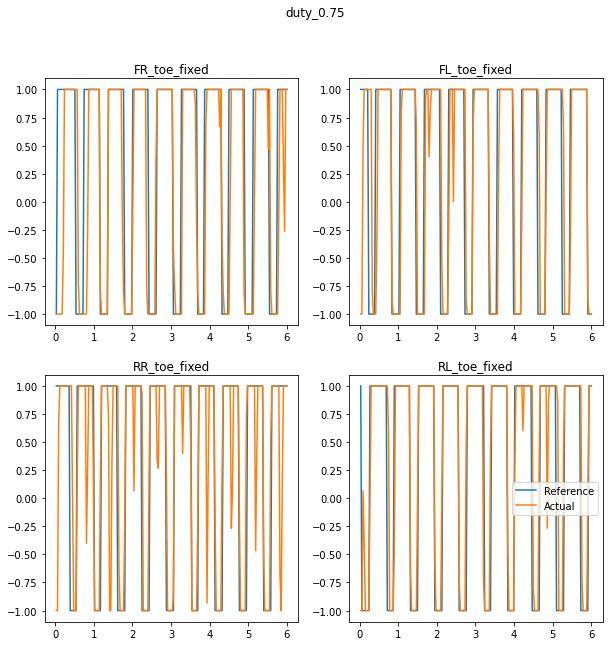

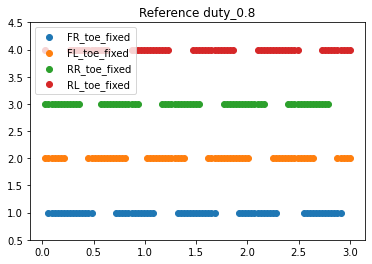

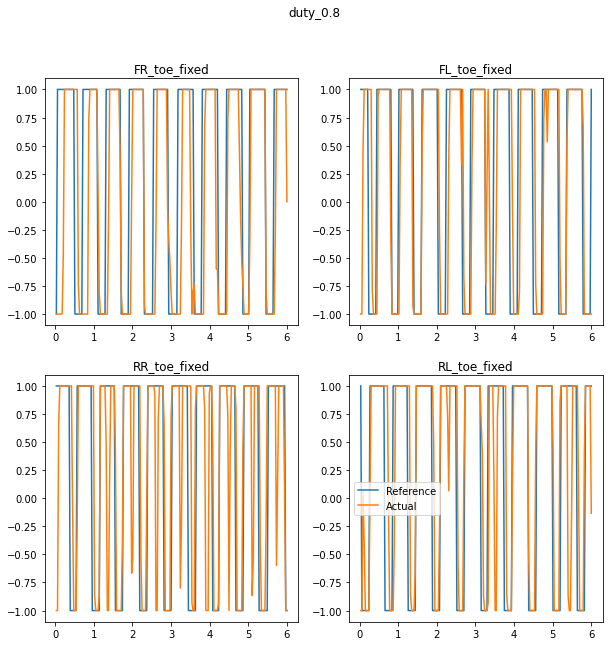

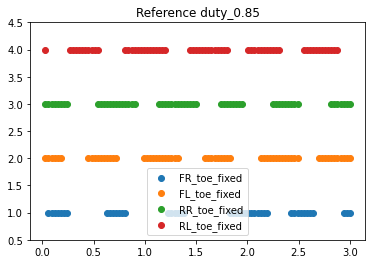

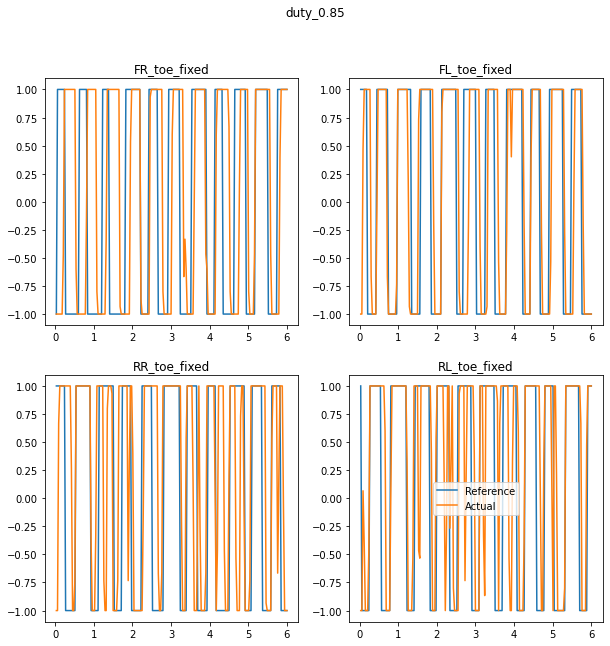

In [4]:
model_dir = project_dir / 'logs/trot_rew_fn_experiments' / 'ppo' / 'A1GymEnv-v0_5'
stats_dirs = [
    model_dir / 'test_var_duty' / f'duty_{str(round(duty,2))}' \
        for duty in np.linspace(0.55, 0.9, 7, endpoint=False)
]
# stats_dir1 = model_dir / 'experiments' / 'vary_freq' / 'train_1.0Hz_test_1.0Hz_alpha_10.0'
# stats_dir2 = model_dir / 'experiments' / 'vary_freq' / 'train_1.0Hz_test_2.0Hz'

statss = [load_robot_states(sd) for sd in stats_dirs]
normalizer = load_normalizer(model_dir)

def plot_foot_contact_sequence(stats, stats_dir, normalizer):
    import matplotlib.pyplot as plt 
    
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, -4:]
    act_foot_contacts = (0.03 - 2 * stats[3]) / 0.03
    # Every cycle will result in an overall +4 to the absolute difference of consec. terms
    num_cycles = np.sum(np.abs(ref_foot_contacts[:-1] - ref_foot_contacts[1:]), axis=0) / 4
    print(num_cycles)
    
    plt.figure()
    plt.title(f"Reference {stats_dir.name}")
    plt.ylim(0.5, 4.5)
    for i in range(4):    
        plt.scatter(time[:100], ref_foot_contacts[:100, i] * (i+1), label = foot_names[i])
    plt.legend()

    
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    fig.suptitle(stats_dir.name)
    idxes = [(0,0), (0,1), (1,0), (1,1)]
    for i in range(4):
        ax[idxes[i]].set_title(f"{foot_names[i]}")
        ax[idxes[i]].plot(time[:200], ref_foot_contacts[:200, i], label = 'Reference')
        ax[idxes[i]].plot(time[:200], act_foot_contacts[:200, i], label = 'Actual')
        plt.legend()

for stats, stats_dir in zip(statss, stats_dirs):
    plot_foot_contact_sequence(stats, stats_dir, normalizer)
    

FR_toe_fixed 0.6123903232489507 5.63701292147772e-104
FL_toe_fixed 0.711637866072198 3.398543179118869e-155
RR_toe_fixed 0.7810493992598294 2.687456168739022e-206
RL_toe_fixed 0.7601703529872642 4.210811769438492e-189

FR_toe_fixed 0.6480504419119502 3.56509108683831e-120
FL_toe_fixed 0.7466359339830148 7.18738684767142e-179
RR_toe_fixed 0.8232775171495436 1.1237237325591217e-247
RL_toe_fixed 0.7612320283783991 6.208175891530176e-190

FR_toe_fixed 0.6708850198322625 9.591853606398986e-132
FL_toe_fixed 0.7423535499446456 9.106793042054283e-176
RR_toe_fixed 0.8109635055544314 1.5355371293425482e-234
RL_toe_fixed 0.7551242359217588 3.2923113515033646e-185

FR_toe_fixed 0.6704297673742167 1.6699588437878007e-131
FL_toe_fixed 0.7445213407135314 2.4915344739435045e-177
RR_toe_fixed 0.8020672030643338 1.2299804445583965e-225
RL_toe_fixed 0.7742793982944758 1.610979527022847e-200

FR_toe_fixed 0.7615075188265606 3.771508521477867e-190
FL_toe_fixed 0.7591874579248495 2.4559429872237777e-188
RR_

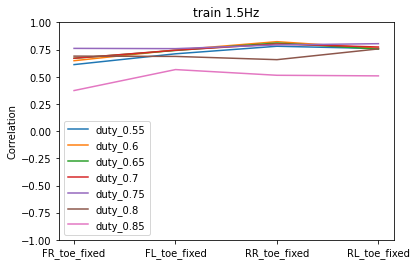

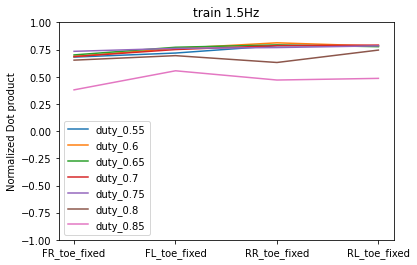

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def compute_correlation(stats, normalizer, ax, label=None):
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, -4:]
    act_foot_contacts = (0.03 - 2 * stats[3]) / 0.03
    corrs = np.zeros(4,)
    for i in range(4):
        corr, p = spearmanr(act_foot_contacts[:,i], ref_foot_contacts[:,i])
        print(foot_names[i], corr, p)
        corrs[i] = corr
    ax.plot(foot_names, corrs, label=label)

def compute_dot_prod(stats, normalizer, ax, label=None):
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, -4:]
    act_foot_contacts = (0.03 - 2 * stats[3]) / 0.03
    dot_prods = np.zeros(4,)
    for i in range(4):
        dot_prod = np.dot(act_foot_contacts[:,i], ref_foot_contacts[:,i])
        dot_prod = dot_prod / (ref_foot_contacts[:,i] ** 2).sum(axis=0) 
        print(foot_names[i], dot_prod)
        dot_prods[i] = dot_prod
    ax.plot(foot_names, dot_prods, label=label)
    
labels = [sd.name for sd in stats_dirs]

fig, ax = plt.subplots()
ax.set_ylim((-1.0, 1.0))

# labels = ['test_1.0Hz', 'test_1.5Hz', 'test_2.0Hz']
for i, stats in enumerate(statss):
    compute_correlation(stats, normalizer, ax, label = labels[i])
    print()
ax.set_title("train 1.5Hz")
ax.set_ylabel("Correlation")
ax.legend()

fig, ax = plt.subplots()
ax.set_ylim((-1.0, 1.0))
# labels = ['test_1.0Hz', 'test_1.5Hz', 'test_2.0Hz']
for i, stats in enumerate(statss):
    compute_dot_prod(stats, normalizer, ax, label = labels[i])
    print()
ax.set_title("train 1.5Hz")
ax.set_ylabel("Normalized Dot product")
ax.legend()